# Diffusion Inference

In [3]:
import matplotlib.pyplot as plt

from imports import *
from PushTDataset import *
from Components import *
from dynamics import *
dataset_pushT = load_dataset_push_t()


### 2D Inference ####
A_mat, B_mat, _, _, _, _ = dynamics_2D()
dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed = load_dataset_lqr2d()
# ckpt_path = 'pretrained/LQR2D_shr1_100_edim256_ks5_par6_53e07_04_23_23_37_29/model_ema_LQR2D_99.ckpt' # full model

ckpt_path = 'pretrained/LQR2D_shr1_100_edim256_ks5_par4_74e07_04_24_09_04_47/model_ema_LQR2D_99.ckpt' # full model
SHRINK = int(ckpt_path.split('shr')[1][0])


# #### 3D Inference ####
# A_mat, B_mat, _, _, _, name = dynamics_3D()
# dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed = load_dataset_lqr3d()
# ckpt_path = 'pretrained/LQR3D_shr2_04_23_18_29_38/model_LQR3D_ema_99_100_shr2.ckpt'
# SHRINK = 2

#### Drone Inference ####
# A_mat, B_mat, _, _, _, name = dynamics_Drone()
# dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed = load_dataset_drone()

# dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed = load_dataset_lqr2d_observation()


# save training data statistics (min, max) for each dim
stats = dataset_ours.stats

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create network object
down_dims = [256//SHRINK, 1024//SHRINK] # 512//SHRINK,
print(down_dims)
# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    down_dims = down_dims,
)


# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

[LQR2D][@carlo change] Obs: x, x_dot, y, y_dot
[@carlo change] Action: x_acc, y_ acc (?)
Observation Dim:  4 Action Dim:  2
[256, 1024]
number of parameters: 4.744755e+07


In [4]:
#@markdown ### **Loading Pretrained Checkpoint**
#@markdown Set `load_pretrained = True` to load pretrained weights.

load_pretrained = True
if load_pretrained:
  # ckpt_path = "pretrained/model_99"
  # ckpt_path = "pretrained/model_3D_70_32"
  # ckpt_path = 'pretrained/model_3D_ema_99_100_32'
  # ckpt_path = 'pretrained/modelsDRONE_32/model_Drone_ema_99_100_32'
  # ckpt_path = 'pretrained/modelsDRONE_32/model_Drone_99_100_32'
  # ckpt_path = 'pretrained/modelsDRONE_64/model_Drone_99_100_64'
  # ckpt_path ='pretrained/LQR2D_obs_04_23_14_38_22/model_LQR2D_obs_ema_99_100_64'
  # ckpt_path = 'modelsDRONE_32/model_Drone_99_100_32'

  state_dict = torch.load(ckpt_path, map_location='cuda')
  ema_noise_pred_net = noise_pred_net
  ema_noise_pred_net.load_state_dict(state_dict)
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")



Pretrained weights loaded.


# **Inference**

In [ ]:
# limit enviornment interaction to 200 steps before termination
max_steps = 400
n_sim = 100

ended_correctly = 0
REWARD = np.zeros((n_sim, 3))

for n_sim_idx in range(n_sim):
    print(n_sim_idx, end = ' ')
    np.random.seed(n_sim_idx + 10000) # seed was between 0 and 500 in the training set


    # WE SHOULD STRUCTURE THIS BETTER get first observation
    obs = np.random.random(obs_dim)*10-5
    # obs = np.array([ 0.81204461, -2.81407099, -2.26550367, -1.43074666])
    if obs_dim == 4:
        obs[1], obs[3] = 0, 0 # 2d
    if obs_dim == 6:
        obs[1], obs[3], obs[5] = 0, 0, 0 # 3d
    if obs_dim > 8:
        obs[3:] = 0 # 9, 10, 11,


    OBS = []
    ACTION_PRED = []
    ############ obs
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)
    # save visualization and rewards
    # imgs = [env.render(mode='rgb_array')]
    rewards = list()
    done = False
    step_idx = 0
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # normalize observation
            nobs = normalize_data(obs_seq, stats=stats['obs'])
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)

            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()

            # print('naction: ', action_pred.shape)
            # (B, pred_horizon, action_dim)
            naction = naction[0]
            action_pred = unnormalize_data(naction, stats=stats['action'])

            # print('action_pred: ', action_pred.shape)

            # only take action_horizon number of actions
            start = obs_horizon - 1 # obs horizon is 2
            end = start + action_horizon
            action = action_pred[start:end,:]
            # (action_horizon, action_dim)
            # print('action_pred: ', action.shape)

            # execute action_horizon number of steps
            # without replanning
            for i in range(len(action)):

                OBS.append(obs)
                ACTION_PRED.append(action)

                # stepping env
                # obs, reward, done, info = env.step(action[i])
                obs = A_mat@obs + B_mat@action[i]

                dist = fn_distance(obs) # how far are we
                speed = fn_speed(obs)

                rew_enable = dist < 1
                reward = rew_enable*(1 - dist)

                done = reward > 0.95 and speed < 0.1

                obs_deque.append(obs)

                # and reward/vis
                rewards.append(reward)
                # imgs.append(env.render(mode='rgb_array'))

                if done:
                    ended_correctly+=1
                    REWARD[n_sim_idx,:] = reward, max(rewards), step_idx

                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(reward=reward)
                if step_idx > max_steps:
                    done = True


                if done:
                    break

    # print out the maximum target coverage
    print('Score: ', max(rewards))

    # visualize
    # from IPython.display import Video
    # vwrite('vis.mp4', imgs)
    # Video('vis.mp4', embed=True, width=256, height=256)

0 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9504934880601303
1 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9502597139403395
2 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9506975994606209
3 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9734312995759682
4 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.952782889622675
5 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9501076323289365
6 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9502913184171522
7 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9514432792825384
8 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.950118825657207
9 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.951075902990715
10 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.992584831993226
11 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9506640952716516
12 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9504030810131451
13 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9504075058751911
14 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9505391631527036
15 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9502244363383018
16 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.951387999778355
17 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9567572583608983
18 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9500734295583337
19 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

Score:  0.9507032506977432
20 

Eval:   0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
with open(f'datasets/inference_2D_.pkl', 'wb') as handle:
    pickle.dump(REWARD, handle, protocol=pickle.HIGHEST_PROTOCOL)


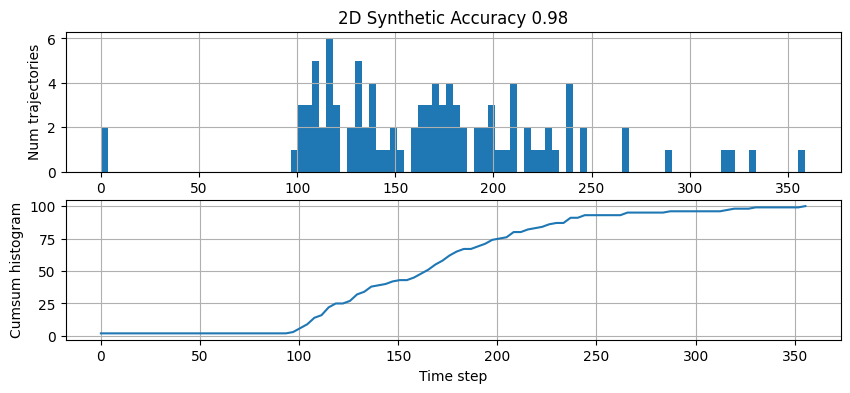

In [65]:
# plt.plot(REWARD[:,0])
# plt.plot(REWARD[:,1])

# plt.plot(300*(REWARD[:,2] == 0))
# plt.plot(REWARD[:,2] )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 4));
freq, thres, _ = ax1.hist(REWARD[:,2], bins = 100);
ax2.plot(thres[:-1], np.cumsum(freq));
# ax3.plot(REWARD[:,2])
ax1.set_ylabel('Num trajectories');
ax2.set_ylabel('Cumsum histogram');
ax2.set_xlabel('Time step');
ax1.grid(); ax2.grid();
ax1.set_title(f'2D Synthetic Accuracy {sum(REWARD[:,0] > 0.5)/100.:.2f}')
plt.savefig('2D_bins.jpg') #, tight_layout = True)



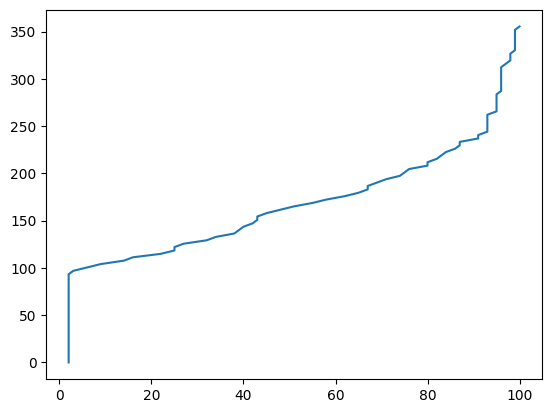

(117, 6)


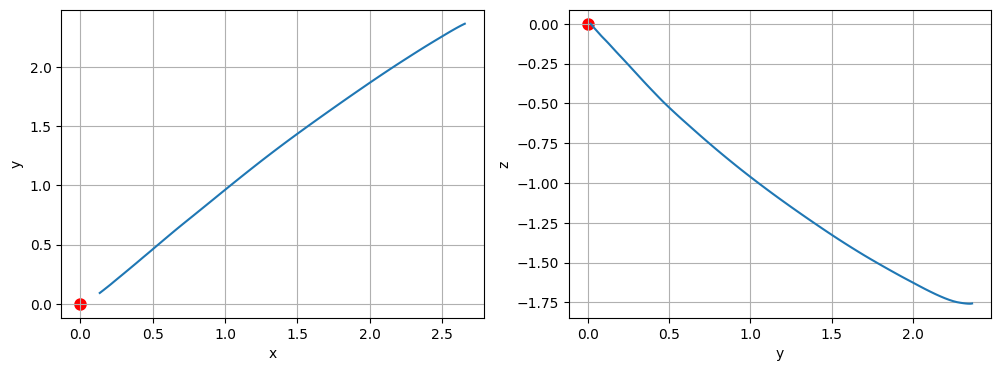

In [15]:
OBS = np.array(OBS)
print(OBS.shape)
T_end = 100
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
ax1.plot(OBS[:T_end,0], OBS[:T_end,2]); ax1.scatter(0,0, color= 'r', linewidth=3,);
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()
ax2.plot(OBS[:,2], OBS[:,4]); ax2.scatter(0,0, color= 'r', linewidth=3,);
ax2.set_xlabel('y'); ax2.set_ylabel('z'); ax2.grid()

plt.show()

# Visualizations

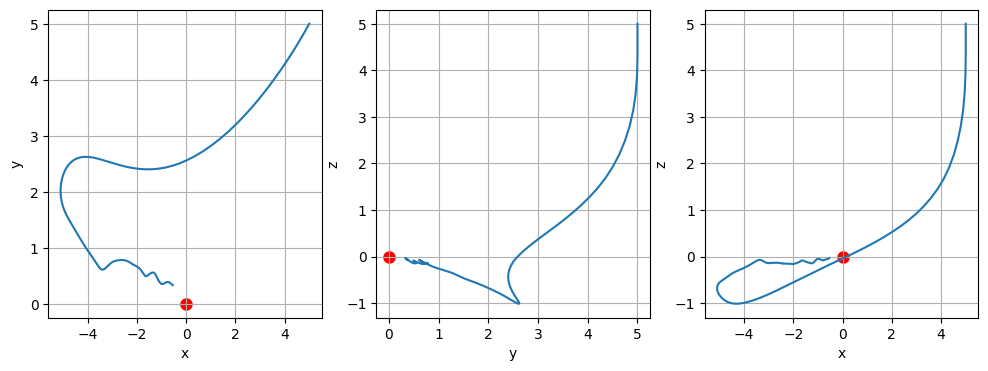

[-0.54293202  0.33101718 -0.02896317  0.11252511 -0.04216489  0.03295834
 -0.00367185  0.00484187 -0.02238284 -0.01354116  0.0180512   0.00996688]


In [41]:
import matplotlib.patches as patches

OBS = np.array(OBS)
# 3D PLOT
# ax = plt.figure().add_subplot(projection='3d') #figsize = (10,10)
# ax.plot(OBS[:,0], OBS[:,2], OBS[:,4]); ax.grid()
# ax.scatter(0,0,0,color= 'r', linewidth=3,);

# # 2D Projection 3D Plot
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
# ax1.plot(OBS[:,0], OBS[:,2]); ax1.scatter(0,0, color= 'r', linewidth=3,);
# ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()
# ax2.plot(OBS[:,2], OBS[:,4]); ax2.scatter(0,0, color= 'r', linewidth=3,);
# ax2.set_xlabel('y'); ax2.set_ylabel('z'); ax2.grid()
# ax3.plot(OBS[:,0], OBS[:,4]); ax3.scatter(0,0, color= 'r', linewidth=3,);
# ax3.set_xlabel('x'); ax3.set_ylabel('z'); ax3.grid()


# 2D Projection 3D Plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
ax1.plot(OBS[:,0], OBS[:,1]); ax1.scatter(0,0, color= 'r', linewidth=3,);
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.grid()
ax2.plot(OBS[:,1], OBS[:,2]); ax2.scatter(0,0, color= 'r', linewidth=3,);
ax2.set_xlabel('y'); ax2.set_ylabel('z'); ax2.grid()
ax3.plot(OBS[:,0], OBS[:,2]); ax3.scatter(0,0, color= 'r', linewidth=3,);
ax3.set_xlabel('x'); ax3.set_ylabel('z'); ax3.grid()



plt.show()
# ax2.plot(OBS[:,1]); ax2.grid()
# ax3.plot(OBS[:,3]); ax3.grid()
# rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
# ax1.add_patch(rect)
print(OBS[-1])

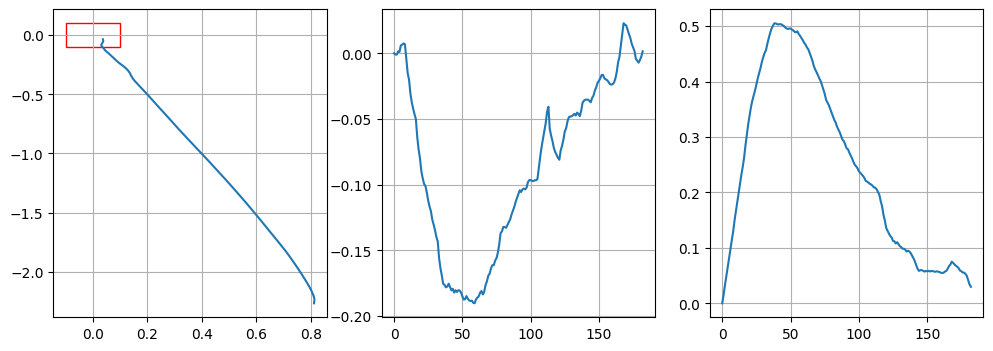

In [16]:
import matplotlib.patches as patches

OBS = np.array(OBS)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

ax1.plot(OBS[:,0], OBS[:,2]); ax1.grid()
ax2.plot(OBS[:,1]); ax2.grid()
ax3.plot(OBS[:,3]); ax3.grid()
rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)


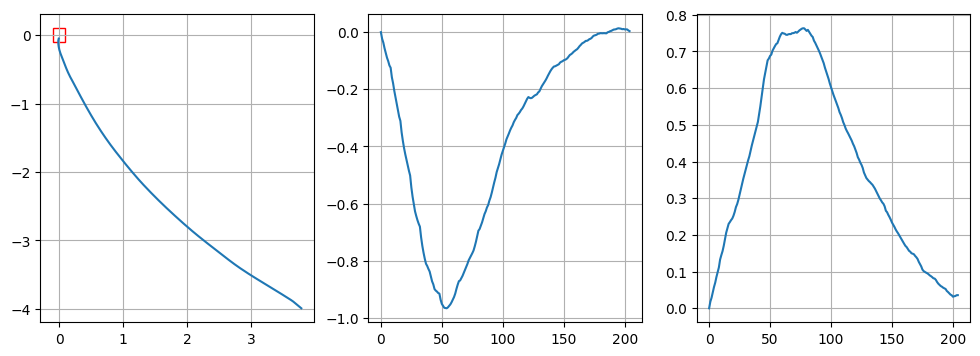

In [62]:
import matplotlib.patches as patches

OBS = np.array(OBS)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

ax1.plot(OBS[:,0], OBS[:,2]); ax1.grid()
ax2.plot(OBS[:,1]); ax2.grid()
ax3.plot(OBS[:,3]); ax3.grid()
rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)
